In [3]:
FILENO= 1 #To distinguish the output file name3
debug=1  #Whethere or not in debuging mode
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

In [4]:
predictors=[]
def do_next_Click( df,agg_suffix='nextClick', agg_type='float32'):
    
    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
    # {'groupby': ['ip', 'channel']},
    # {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)
        
        predictors.append(new_feature)
        gc.collect()
    return (df)

In [5]:
def do_prev_Click( df,agg_suffix='prevClick', agg_type='float32'):

    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    #{'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    #{'groupby': ['ip', 'os', 'device']},
    #{'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        
        predictors.append(new_feature)
        gc.collect()
    return (df)

In [6]:
def do_count( df, group_cols, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [7]:
def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [8]:
def do_cumcount( df, group_cols, counted,agg_type='uint16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [9]:
def do_mean( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_mean'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating mean of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [10]:
def do_var( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_var'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating variance of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [11]:
###  A function is written to train the lightGBM model with different given parameters
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.05,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 20000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    del dtrain
    gc.collect()
    del dvalid
    gc.collect()

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[ xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)


*** debug parameter set: this is a test run for debugging purposes ***


In [12]:
def DO(frm,to,fileno):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint8',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }

    print('loading train data...',frm,to)
    train_df = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

    print('loading test data...')
    if debug:
        test_df = pd.read_csv("../input/test.csv", nrows=18000000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv("../input/test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

    len_train = len(train_df)
    train_df=train_df.append(test_df)
    
    del test_df
        
    gc.collect()
    train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('int8')
    train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('int8') 
    train_df = do_next_Click( train_df,agg_suffix='nextClick', agg_type='float32'  ); gc.collect()
    train_df = do_prev_Click( train_df,agg_suffix='prevClick', agg_type='float32'  ); gc.collect()  ## Removed temporarily due RAM sortage. 
    
    train_df = do_countuniq( train_df, ['ip'], 'channel' ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app'); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'day'], 'hour' ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'app'); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'app'], 'os'); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'device'); gc.collect()
    train_df = do_countuniq( train_df, ['app'], 'channel'); gc.collect()
    train_df = do_cumcount( train_df, ['ip'], 'os'); gc.collect()
    train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app'); gc.collect()
    train_df = do_count( train_df, ['ip', 'day', 'hour'] ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app']); gc.collect()
    train_df = do_count( train_df, ['ip', 'app', 'os']); gc.collect()
    # train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour'); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour'); gc.collect()
    # train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day'); gc.collect()
    # train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour' ); gc.collect()
    
    del train_df['day']
    gc.collect()
    gc.collect()
    
    
    print('\n\nBefore appending predictors...\n\n',sorted(predictors))
    target = 'is_attributed'
    word= ['app','device','os', 'channel', 'hour']
    for feature in word:
        if feature not in predictors:
            predictors.append(feature)
    categorical = ['app', 'device', 'os', 'channel', 'hour']
    print('\n\nAfter appending predictors...\n\n',sorted(predictors))

    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("\ntrain size: ", len(train_df))
    print("\nvalid size: ", len(val_df))
    print("\ntest size : ", len(test_df))

    sub = pd.DataFrame()
    sub['click_id'] = test_df['click_id'].astype('int')

    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.10,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }
    (bst,best_iteration) = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()


    ax = lgb.plot_importance(bst, max_num_features=300)
    
    plt.savefig('test%d.png'%(fileno), dpi=600, bbox_inches='tight')
    plt.show()

    print("Predicting...")
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
#     if not debug:
#         print("writing...")
    sub.to_csv('sub_it%d.csv'%(fileno),index=False,float_format='%.9f')
    print("done...")
    return sub


loading train data... 0 100000
loading test data...


C:\Users\Akhil Upadhyay\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


>> 
Extracting nextClick time calculation features...

>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to nextClick in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to nextClick in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to nextClick in: ip_os_device_app_nextClick
>> 
Extracting prevClick time calculation features...

>> Grouping by ['ip', 'channel'], and saving time to prevClick in: ip_channel_prevClick
>> Grouping by ['ip', 'os'], and saving time to prevClick in: ip_os_prevClick

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip', 'day'] ... and saved in ip_day_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_

C:\Users\Akhil Upadhyay\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.936003
[20]	valid's auc: 0.91561
[30]	valid's auc: 0.847075
Early stopping, best iteration is:
[1]	valid's auc: 0.949282

Model Report
bst1.best_iteration:  1
auc: 0.949281586569892
[8.143460988998413]: model training time


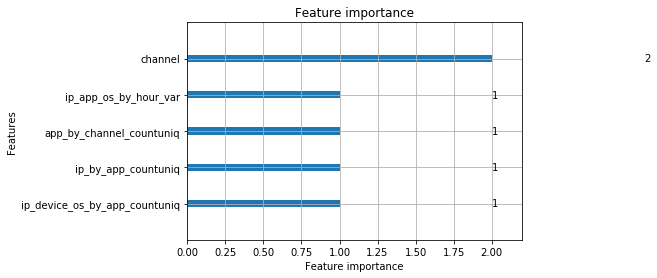

Predicting...


In [ ]:
nrows=100000
nchunk=25000
val_size=1250

frm=nrows-100000
if debug:
    frm=0
    nchunk=100000
    val_size=20000

to=frm+nchunk

sub=DO(frm,to,FILENO)